In [ ]:
### supervised machine learning
### Coded by Eleanor Middlemas (Jupiter, formerly University of Colorado)
### Additional code/commenting from Jennifer Kay (University of Colorado) 
### Last updated March 31, 2022

import pandas as pd
import numpy as np
import datetime
import time
from google.colab import files

In [ ]:
### upload file christman_2016.csv
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))#

Saving christman_2016.csv to christman_2016.csv
User uploaded file "christman_2016.csv" with length 510492 bytes


In [ ]:
# read in the data
df = pd.read_csv("christman_2016.csv")
# preview data (also through df.head() & df.tail())
df

,day,hour,temp_F,RH,dewtemp_F,wind_mph,wind_dir,windgust,windgust_dir,pres_Hg,SOLIN_Wm2,Prec_inches
0,42370,0.000000,7.0,72.2,-0.1,1.2,234,3.9,224,851.30,0.0,0.0
1,42370,0.041667,5.4,74.3,-1.0,3.4,299,7.1,302,850.82,0.0,0.0
2,42370,0.083333,6.4,73.8,-0.2,2.8,200,7.0,301,849.83,0.0,0.0
3,42370,0.125000,3.0,73.5,-3.6,2.9,309,6.1,349,850.69,0.0,0.0
4,42370,0.166667,3.7,76.9,-1.9,3.1,346,5.3,255,848.24,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8779,42735,0.791667,22.3,74.3,15.4,0.9,221,3.3,202,833.32,0.0,0.0
8780,42735,0.833333,20.3,80.4,15.3,0.6,279,2.9,279,833.45,0.1,0.0
8781,42735,0.875000,19.9,81.1,15.1,0.5,197,2.5,279,833.01,0.1,0.0
8782,42735,0.916667,17.8,82.8,13.5,2.0,353,4.8,352,832.78,0.1,0.0


**Deal with the time dimension**

In [ ]:
df.day.nunique() ## How many days are in this dataset?

366

In [ ]:
##Optional: transform the day column into a readable date. Run this ONCE.
df['day'] = [datetime.date.fromordinal(day+693594) for day in df['day']]

**Q1. What exactly are you trying to predict?**

First, split data into predictor & predictands. 

In [ ]:
##I'm going to create (or "engineer") a new feature that indicates whether precipitation occurred. 
## Perform this step ONCE.

print(df.columns) # print so that you can see what is the variable called that indicates precipitation amount?

df['prec_occur'] = np.array(df.Prec_inches!=0).astype(int)

Index(['day', 'hour', 'temp_F', 'RH', 'dewtemp_F', 'wind_mph', 'wind_dir',
       'windgust', 'windgust_dir', 'pres_Hg', 'SOLIN_Wm2', 'Prec_inches'],
      dtype='object')


In [ ]:
#Next, select the data that will be predictors.
predictors = df.copy(deep=True)  # here, we use "deep = True" so that changes to predictors won't be made to the df.

#Next, we drop some variables that shouldn't be used to predict whether or not there is rain.
predictors = df.drop(['day','hour','Prec_inches'],axis=1) 
predictors

,temp_F,RH,dewtemp_F,wind_mph,wind_dir,windgust,windgust_dir,pres_Hg,SOLIN_Wm2,prec_occur
0,7.0,72.2,-0.1,1.2,234,3.9,224,851.30,0.0,0
1,5.4,74.3,-1.0,3.4,299,7.1,302,850.82,0.0,0
2,6.4,73.8,-0.2,2.8,200,7.0,301,849.83,0.0,0
3,3.0,73.5,-3.6,2.9,309,6.1,349,850.69,0.0,0
4,3.7,76.9,-1.9,3.1,346,5.3,255,848.24,0.0,0
...,...,...,...,...,...,...,...,...,...,...
8779,22.3,74.3,15.4,0.9,221,3.3,202,833.32,0.0,0
8780,20.3,80.4,15.3,0.6,279,2.9,279,833.45,0.1,0
8781,19.9,81.1,15.1,0.5,197,2.5,279,833.01,0.1,0
8782,17.8,82.8,13.5,2.0,353,4.8,352,832.78,0.1,0


In [ ]:
## Great, that worked. Now I will assign everything but "prec" to be the predictor array "x", 
## and prec will be the predictand vector "y".

x = predictors.drop('prec_occur',axis=1)
y = predictors.prec_occur

**Q2 & Q3 do not need to be addressed in our dataset.**

**Q4. How will you validate your model?**

perform a test-train split to validate our trained model.
This step must be performed before each time the model is trained to ensure we are not 
baking in any bias among the models we train. That also means the following two steps must 
also be performed prior to training each model as well. For this reason, I wrote functions to call 
easily before each model training.

In [ ]:
from sklearn.model_selection import train_test_split
from random import randint

In [ ]:
def define_holdout_data(x, y, verbose):
    """Perform a 80/20 test-train split (80% of data is training, 20% is testing). Split is randomized with each call."""
    random_state = randint(0,1000)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=random_state)
    if verbose==True:
        print("Prior to scaling and rebalacing...")
        print("Shape of training predictors: "+str(np.shape(x_train)))
        print("Shape of testing predictors: "+str(np.shape(x_test)))
        print("Shape of training predictands: "+str(np.shape(y_train)))
        print("Shape of testing predictands: "+str(np.shape(y_test)))
        print(" ")
    return x_train, x_test, y_train, y_test

**Q5. Do your features have the same variance?**

We must normalize the features. In machine learning this is called Feature Scaling".
We do this for the same reason we normalized prior to running the K-Means clustering algorithm.

The difference here is that I will keep the data as a pandas dataframe rather than converting it to a numpy array beforehand. The "fit_transform" function outputs a numpy array, but we will convert back to a dataframe so that re-balancing the dataset is easier.

Note: If my predictand wasn't binary, then I would also want to normalize that as well.

In [ ]:
from sklearn import preprocessing

In [ ]:
def scale_data(x_train, x_test):
    """
    Scale training data so that model reaches optimized weights much faster. 
    
    *All data that enters the model should use the same scaling used to scale the training data.*
    Thus, we also perform scaling on testing data for validation later. 
    Additionally, we return the scaler used to scale any other future input data.
    """
    
    scaler = preprocessing.MinMaxScaler() # normalize 
    x_train_scaled = pd.DataFrame(data=scaler.fit_transform(x_train),index=x_train.index,columns=x_train.columns) 
    x_test_scaled = pd.DataFrame(data=scaler.transform(x_test),index=x_test.index,columns=x_test.columns)
    
    return scaler, x_train_scaled, x_test_scaled

**Q6. Are there the same number of observations for each outcome or class?**
Luckily, we have the same number of observations for each feature (8784). 

**Question:** But do we have the same number of outcomes for our predictand - i.e., the same number of hours that are precipitating as those that are non-precipitating?

In [ ]:
df['prec_occur'].value_counts()

0    8501
1     283
Name: prec_occur, dtype: int64

**Answer:** Definitely not. The outcomes we are trying to predict are extremely unbalanced. Non-precip hours occur 30x more than precip hours. This class imbalance may bias the model because precip hours are underrepresented, which means the model won't have as many instances of precip hours to learn to distinguish precip hours from non-precip hours.

There are a number of out-of-the-box functions that resample data very precisely. The one I use below simply randomly oversamples the existing precipitating observation data to balance the dataset.

Note: This function should be called on both training and testing data separately.

In [ ]:
from sklearn.utils import resample

In [ ]:
def balance_data(x,y,verbose):
    """Resample data ensure model is not biased towards a particular outcome of precip or no precip."""
    # Combine again to one dataframe to ensure both the predictor and predictand are resampled from the same 
    # observations based on predictand outcomes. 
    dataset = pd.concat([x, y],axis=1)

    # Separating classes
    raining = dataset[dataset['prec_occur'] == 1]
    not_raining = dataset[dataset['prec_occur'] == 0]

    random_state = randint(0,1000)
    oversample = resample(raining, 
                           replace=True, 
                           n_samples=len(not_raining), #set the number of samples to equal the number of the majority class
                           random_state=random_state)

    # Returning to new training set
    oversample_dataset = pd.concat([not_raining, oversample])

    # reseparate oversampled data into X and y sets
    x_bal = oversample_dataset.drop(['prec_occur'], axis=1)
    y_bal = oversample_dataset['prec_occur']

    if verbose==True:
        print("After scaling and rebalacing...")
        print("Shape of predictors: "+str(np.shape(x_bal)))
        print("Shape of predictands: "+str(np.shape(y_bal)))
        print(" ")
    
    return x_bal, y_bal

**Having got this far -- Now, let's put the data prep code from questions 1-6 into a pipeline.  In other words we will write a single function to accomplish everything we have done so far in this notebook.**


In [ ]:
def dataprep_pipeline(x, y, verbose):
    """ Combines all the functions defined above so that the user only has to 
    call one function to do all data pre-processing. """
    # verbose=True prints the shapes of input & output data

    # split into training & testing data
    x_train, x_test, y_train, y_test = define_holdout_data(x, y, verbose) 

    # perform feature scaling
    scaler, x_train_scaled, x_test_scaled = scale_data(x_train, x_test)

    # rebalance according to outcomes (i.e., the number of precipitating 
    # observations & non-precipitating outcomes should be equal)
    if verbose==True:
        print("for training data... ")
    x_train_bal, y_train_bal = balance_data(x_train_scaled, y_train, verbose)
    if verbose==True:
        print("for testing data... ")
    x_test_bal, y_test_bal = balance_data(x_test_scaled, y_test, verbose)
    
    return x_train_bal, y_train_bal, x_test_bal, y_test_bal

**Q7. What are the appropriate metrics for assessing your model?**
These metrics will be used to evaluate the model after training. Thus, these functions will also be called for each model.

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

First, define functions for evaluating models
I'm simply going to train various models and then look at their model metrics. Then we can make a prediction based on some selected observation to obtain a likelihood that it's raining, and we can compare with our own eyes whether the model gets it right.

Below are some commonly-used metrics for assessing the value of a given Machine Learning model.

"**True Positive (TP)**" Is the number of times the model predicts a positive when the observation is actually positive. In our case, the model predicts that its raining when it is actually raining.<br>
"**False Positive (FP)**" The number of times the model guesses that it's raining when it's not actually raining.<br>
The same applies to **True Negatives (TN)** (correctly predicting that it's not raining) and **False Negatives (FN)** (predicting no rain when it's actually raining).


 - **Precision = TP/(TP + FP)**: The proportion of predicted precipitating events that are actually precipitating.
 - **Accuracy = (TP + TN)/(total)**: The proportion of precipitating hours or non-precipitating hours that are correctly predicted by the model.
 - **Recall = TP/(TP + FN)**: The proportion of precipitating hours that are correctly predicted by the model.<br>
<br>
Other important metrics that we aren't going to look at today:
 - **F1**: a way to capture how well the model predicts the hours that it's actually precipitating.
 - **ROC/AUC**: how well the model separates precipitating hours from non-precipitating hours.

In [ ]:
# Print rounded metrics for each model.
def bin_metrics(x, y):
    """Prints accuracy and recall metrics for evaluating 
    classification predictions."""
    
    accuracy = metrics.accuracy_score(x, y)
    recall = metrics.recall_score(x, y)

    print('Accuracy:', round(accuracy, 4))
    print('Recall:', round(recall, 4))
    
    return accuracy, recall


# Plot confusion matrix
def plot_cm(x, y):
    """Plots the confusion matrix to visualize true 
    & false positives & negatives"""
    cm = confusion_matrix(x, y)
    df_cm = pd.DataFrame(cm, columns=np.unique(x), index = np.unique(x))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 25}, fmt='g')# font size
    plt.ylim([0, 2])
    plt.xticks([0.5, 1.5], ['Negatives','Positives'])
    plt.yticks([0.5, 1.5], ['Negatives','Positives'])

In [ ]:
##Based on our answer to number 7 under the "1. Data Preparation" section above, 
##I will be using Accuracy and Recall to compare these four different models.

#Another way we can evaluate the models is to compare precipitation likelihood given the same set of atmospheric conditions.
#First, let's choose some observation in the pre-scaled dataset shows that it's raining, and then find the corresponding scaled observation:

In [ ]:
def rand_atmos_conditions_precip(index='rand'):
    """
    Function returns atmospheric conditions in a dataframe as well as the scaled
    conditions in a numpy array so that they output a prediction in the model.
    
    If no input is passed, the function will randomly generate an in index to 
    choose from those observations in some training data with precipitation. 
    Otherwise, an integer index between 0 and 200 should be passed.
    """
    # First, perform a test-train split
    x_train, x_test, y_train, _ = define_holdout_data(x, y, verbose=False) 

    # perform feature scaling
    _, x_train_scaled, _ = scale_data(x_train, x_test)

    # this is what will go into the model to output a prediction
    if index=='rand':
        index = randint(0,len(y_train[y_train==1].index)) 
    precipindex = y_train[y_train==1].index.values[index]
    testpredictor = x_train_scaled.loc[precipindex] 
    
    return df.iloc[precipindex], testpredictor    

# Train & Compare four Machine Learning models
Each section below goes through building and training a ML model. In each section, there are a few steps for each model "pipeline":
1. __Randomly perform a test-train split, feature scaling, and resample data to ensure outcomes are balanced__. 
2. __Train your model__.
3. __Assess model metrics with testing and training data__. We begin by first assessing each model's performance by calculating the metrics defined above on the *testing* or *holdout* data; the key here is that the model has never seen this data. <br>__If applicable, tune your model.__ This means choosing new *hyperparameters*, retraining the model, and then reassessing the same model metrics to see if the model yields better results.
3. __Check for model overfitting__. We will also check to see if the model is overfitting by comparing metrics of the testing data to that of the training data. In short, the training data should not be outperforming the testing data.
4. __Actually make a prediction with a single observation__. 

## Model 1: Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
## 1. Perform a test-train split, perform feature scaling, and the rebalance our dataset.
x_train_bal, y_train_bal, x_test_bal, y_test_bal = dataprep_pipeline(x, y, verbose=True)

Prior to scaling and rebalacing...
Shape of training predictors: (7027, 9)
Shape of testing predictors: (1757, 9)
Shape of training predictands: (7027,)
Shape of testing predictands: (1757,)
 
for training data... 
After scaling and rebalacing...
Shape of predictors: (13590, 9)
Shape of predictands: (13590,)
 
for testing data... 
After scaling and rebalacing...
Shape of predictors: (3412, 9)
Shape of predictands: (3412,)
 


In [ ]:
## 2. Train the Logistic Regression model
# initialize the model
lr = LogisticRegression(solver='lbfgs') 
# we choose this particular solver because we're not regularizing or penalizing certain features

# fit the model to scaled & balanced training data. Side note: this is where *Gradient Descent* occurs.
lr.fit(x_train_bal, y_train_bal);

In [ ]:
## 3. Assess Logistic Regression's performance using testing data
##Now that we've "trained" our model, we make predictions using data that the 
## model has never seen before (i.e., our holdout testing data) to see how it performs.

y_pred = lr.predict(x_test_bal)

# Call functions defined above to calculate metrics & plot a confusion matrix based on
# how well model simulates testing data
#plot_cm(y_test_bal, y_pred);
lr_acc, lr_rec = bin_metrics(y_test_bal, y_pred)


Accuracy: 0.8312
Recall: 0.8558


In [ ]:
## TEXT

In [ ]:
##4. Check to see if the Logistic Regression model is overfitting (or underfitting)
#Remember:
#testing metrics > training metrics = underfitting, model is too simple
#testing metrics < training metrics = overfitting, model is too complex

# Compare testing data metrics to data training metrics.
print("Training metrics:")
pred_train= lr.predict(x_train_bal) 
bin_metrics(y_train_bal,pred_train);

# As a reminder, display testing metrics:
print(" ")
print("Testing metrics:")
bin_metrics(y_test_bal, y_pred);

Training metrics:
Accuracy: 0.8444
Recall: 0.8756
 
Testing metrics:
Accuracy: 0.8312
Recall: 0.8558


In [ ]:
## 5. Make a prediction with the Logistic Regression model
#First, we randomly choose some atmospheric conditions using the function defined above. 
#This will be the atmospheric conditions we use for all models we build.

origvals, testpredictor = rand_atmos_conditions_precip()
# print(origvals) # observation from original dataframe
# print(testpredictor) # scaled observation

In [ ]:
# prediction output is in the format [probability no rain, probability rain]
lr_prediction = lr.predict_proba(np.array(testpredictor).reshape(1, -1))[0][1]*100 
print("The meteorological conditions are: ")
print(origvals)
print(" ")
print("There is a {0:.{digits}f}% chance of precipitation given those meteorological conditions.".format(lr_prediction, digits=2))

The meteorological conditions are: 
day             2016-04-16
hour              0.041667
temp_F                35.0
RH                    86.5
dewtemp_F             31.4
wind_mph              13.8
wind_dir               315
windgust              21.0
windgust_dir           324
pres_Hg             840.92
SOLIN_Wm2              0.0
Prec_inches           0.08
prec_occur               1
Name: 2545, dtype: object
 
There is a 95.65% chance of precipitation given those meteorological conditions.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


## Model 2: Random Forest

To understand random forests, one must first understand a [decision tree](https://scikit-learn.org/stable/modules/tree.html#tree). A decision tree is intuitive: it is essentially a flowchart to point to an outcome based on "decisions" for each feature. <br><br>
A Random Forest is an ensemble of decision trees that are randomly constructed based on the features of the dataset and number of decisions. Trees are constructed by randomly choosing a feature to "seed" each tree, and then making rules or associations with other features to lead to the specified outcome.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
##1. Perform a test-train split, perform feature scaling, and the rebalance our dataset.
## Perform a train-test split for cross-validation, perform feature scaling, and 
## rebalance each testing & training dataset.

x_train_bal, y_train_bal, x_test_bal, y_test_bal = dataprep_pipeline(x, y, verbose=False)

In [ ]:
##2. Train (and tuning) the Random Forest model

##Choosing hyperparameters: There are many hyperparameters one can decide upon when 
## tuning the Random Forest classifier. The two we will be adjusting is
##1) The number of estimators or "trees" in the forest
##2) The depth of the tree, or how many "decisions" are made until convergence is reached.

acc_scores = []
rec_scores = []

num_est = [10, 50, 500] # number of trees
depth = [2, 10, 100] # number of decisions
for i in num_est:
    start = time.time()
    print("Number of estimators is "+str(i))

    for k in depth:
        print("depth is "+str(k))
        forest = RandomForestClassifier(n_estimators=i, max_depth=k)
        forest.fit(x_train_bal, y_train_bal)
        
        # cross validate & evaluate metrics based on testing data
        pred_test= forest.predict(x_test_bal)
        acc_val = metrics.accuracy_score(y_test_bal, pred_test)
        acc_scores.append(acc_val)
        rec_val = metrics.recall_score(y_test_bal, pred_test)
        rec_scores.append(rec_val)

    end = time.time()
    print("Random Forest took "+str(end-start)+" seconds.")

Number of estimators is 10
depth is 2
depth is 10
depth is 100
Random Forest took 0.9620890617370605 seconds.
Number of estimators is 50
depth is 2
depth is 10
depth is 100
Random Forest took 2.517953872680664 seconds.
Number of estimators is 500
depth is 2
depth is 10
depth is 100
Random Forest took 18.91431427001953 seconds.


Max Accuracy (black): 0.8381
Max Recall (blue): 0.8121


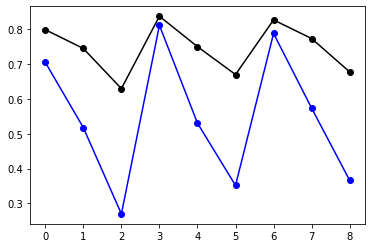

In [ ]:
plt.plot(acc_scores, marker='o', color='black')
plt.plot(rec_scores, marker='o', color='blue')
print("Max Accuracy (black):", round(max(acc_scores), 4))
print("Max Recall (blue):", round(max(rec_scores), 4))

In [ ]:
##Choosing the right hyperparameters for this model requires revisiting which 
##metrics are most important to our question. We want to maximize both recall and accuracy.
#For simplicity, I choose the parameters corresponding to x=0, but 
#I highly suggest you try other combinations of parameters as well.

forest = RandomForestClassifier(n_estimators=10, max_depth=2);
forest.fit(x_train_bal, y_train_bal);

In [ ]:
forest = RandomForestClassifier(n_estimators=10, max_depth=2);
forest.fit(x_train_bal, y_train_bal);

In [ ]:
## 3. Assess the Random Forest's performance using testing data
##Once again, we will use our testing data to make an initial evaluation of how the model is doing.

pred_test= forest.predict(x_test_bal)

# Call functions defined above to calculate metrics & plot a confusion matrix based on
# how well model simulates testing data
forest_acc, forest_rec = bin_metrics(y_test_bal, pred_test)
#plot_cm(y_test_bal, pred_test)


Accuracy: 0.7878
Recall: 0.7436


In [ ]:
## 4. Check to see if the Random Forest is overfitting

# Compare testing data metrics to data training metrics.
print("Training metrics:")
rf_pred_train= forest.predict(x_train_bal) 
bin_metrics(y_train_bal,rf_pred_train);

# As a reminder, display testing metrics:
print(" ")
print("Testing metrics:")
bin_metrics(y_test_bal, pred_test);

Training metrics:
Accuracy: 0.8086
Recall: 0.7883
 
Testing metrics:
Accuracy: 0.7878
Recall: 0.7436


In [ ]:
#Random forests seldom overfit, but if they do, one should try increasing the number of trees, or decreasing the amount of data used to construct each tree. See scikit-learn's Random Forest Classifier webpage for 
#information on more hyperparameters one can tune to address overfitting.

In [ ]:
##5. Make a prediction with the Random Forest

# prediction output is in the format [probability no rain, probability rain]
forest_prediction = forest.predict_proba(np.array(testpredictor).reshape(1, -1))[0][1]*100 
print("The meteorological conditions are: ")
print(origvals)
print(" ")
print("There is a {0:.{digits}f}% chance of precipitation given those meteorological conditions.".format(forest_prediction, digits=2))

The meteorological conditions are: 
day             2016-03-18
hour                 0.125
temp_F                21.3
RH                    89.7
dewtemp_F             18.8
wind_mph              12.0
wind_dir               322
windgust              16.8
windgust_dir           318
pres_Hg             844.75
SOLIN_Wm2              0.1
Prec_inches           0.01
prec_occur               1
Name: 1851, dtype: object
 
There is a 79.78% chance of precipitation given those meteorological conditions.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
model_metrics = pd.DataFrame({'Metrics':['Accuracy','Recall','Prediction example'],
     'Logistic Regression':[lr_acc, lr_rec, lr_prediction],
    'Random Forest':[forest_acc, forest_rec, forest_prediction]})
model_metrics = model_metrics.set_index('Metrics')
model_metrics

,Logistic Regression,Random Forest
Metrics,,
Accuracy,0.831184,0.787763
Recall,0.855803,0.743560
Prediction example,95.652761,79.784011
